In [5]:

import os
import re
import numpy as np
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import json
from result_parser import get_exp_result
from utils.distribution import distr_profile


#fig_width = 10
#plt.rcParams["figure.figsize"] = (fig_width, 6)
#plt.rcParams['font.size'] = 22



=== cifar10 - cossim_zipf_vi3_a0.5_r0 - shard2 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']

bacc summary: [42.97, 49.04, 51.11] -> max: 49.04
target_acc: 46.58800, 95% of bacc 

required epoch
[-1, 199, 199]
['-199.00x', '1.00x', '1.00x']
required time_simu
[-1, 1066.0, 1066.0]
['-1066.00x', '1.00x', '1.00x']

=== cifar10 - cossim_zipf_vi3_a0.5_r1 - shard2 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']

bacc summary: [42.64, 53.21, 52.41] -> max: 52.41
target_acc: 49.78950, 95% of bacc 

required epoch
[-1, 225, 208]
['-225.00x', '1.00x', '1.08x']
required time_simu
[-1, 1295.0, 1195.0]
['-1295.00x', '1.00x', '1.08x']

=== cifar10 - cossim_zipf_vi3_a0.5_r2 - shard2 - select100*0.05 ===
algorithms
['fedavg', 'oort_e0.8', 'algo3_deg1_e0.8_wof100']

bacc summary: [43.0, 49.29, 50.19] -> max: 49.29
target_acc: 46.82550, 95% of bacc 

required epoch
[-1, 302, 296]
['-302.00x', '1.00x', '1.02x']
required time_simu
[-1,

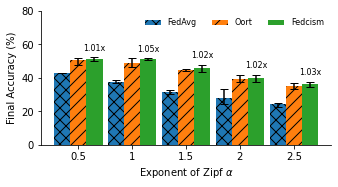

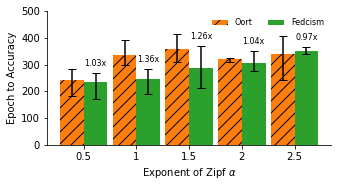

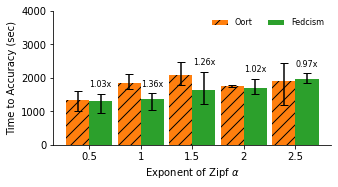

In [12]:
data_distr = 'zipf' # htail, cus
VI = 3
epoch = 500
fig_zoom = 0.3
n_clients = 100

# compare over datasets
acc_threshold = 95
x_labels = [0.5, 1, 1.5, 2, 2.5]
y_labels = ['Final Accuracy (%)',
            'Epoch to Accuracy',
            'Time to Accuracy (sec)']
y_lim = [80, epoch, 4000]
'''
y_labels = ['Final Accuracy(%)',
            'Epoch to Reach {}% Best Acc'.format(acc_threshold),
            'Time to Reach {}% Best Acc'.format(acc_threshold)]
'''
legends = {'fedavg':'FedAvg', 'oort_e0.8':'Oort', 'algo3_deg1_e0.8_wof100':'Fedcism'}
textures = ['xx', '//', None]

for dataset in ['cifar10']:
    for shard_per_user in [2]:
        for frac in [0.05]:
        
            # new fig set
            metrics = {'ACC':[], 'ETA':[], 'TTA':[]}
            for alpha in x_labels:
                bacc_stack = []
                TTAe_stack = []
                TTAt_stack = []

                for RUN in range(3):
                    if alpha == 1:
                        data_distr_file = '{}_dict_users_vi{}_r{}.pkl'.format(data_distr, VI, RUN)
                        result_folder = 'cossim_{}_vi{}_r{}'.format(data_distr, VI, RUN)
                    else:
                        data_distr_file = '{}_dict_users_vi{}_a{}_r{}.pkl'.format(data_distr, VI, alpha, RUN)
                        result_folder = 'cossim_{}_vi{}_a{}_r{}'.format(data_distr, VI, alpha, RUN)

                    algos, color_algos, bacc_algos, required_time = get_exp_result(
                    dataset, data_distr, VI, RUN, data_distr_file, result_folder, legends,
                    shard_per_user, frac, acc_threshold, num_users=n_clients, global_ep=epoch,
                    show_fig=False, save=False)

                    bacc_stack.append(bacc_algos)
                    TTAe_stack.append(required_time['epoch'])
                    TTAt_stack.append(required_time['time_simu'])

                metrics['ACC'].append(bacc_stack)
                metrics['ETA'].append(TTAe_stack)
                metrics['TTA'].append(TTAt_stack)

            # summary 
            x = np.arange(len(x_labels))
            for i, (k, v) in enumerate(metrics.items()):
                fig, ax = plt.subplots(figsize=(16*fig_zoom, 9*fig_zoom))
                if data_distr == 'cus': # alias
                    fig_name = '{}_{}_xa_vi{}_s{}'.format(k, 'sparsez', VI, shard_per_user)
                else:            
                    fig_name = '{}_{}_xa_vi{}_s{}'.format(k, data_distr, VI, shard_per_user)
                fig_path = os.path.join('save', dataset, 'fig', fig_name)

                #plt.title(fig_name, y=1.1)

                cur_algos = algos
                cur_v_T = v_T = np.array(v).T
                if 'TA' in k:
                    cur_algos = algos[1:]
                    cur_v_T = v_T[1:] # [algo][run][data_config]
                for aidx, algo in enumerate(cur_algos):
                    w = 0.9/len(cur_algos)
                    y_avg = cur_v_T[aidx].mean(axis=0)
                    y_max = cur_v_T[aidx].max(axis=0)
                    y_min = cur_v_T[aidx].min(axis=0)
                    y_err = np.vstack((y_max-y_avg, y_avg-y_min))

                    if k == 'ACC':
                        p = ax.bar(x+aidx*w-0.45+w/2, y_avg, yerr=y_err, 
                                    label=legends[algo], width=w,
                                    capsize=4, hatch=textures[aidx])
                        if aidx == 1:
                            base_yavg = y_avg
                        elif aidx == 2:
                            txt = ['{:.2f}x'.format(x) for x in y_avg/base_yavg]
                            ax.bar_label(p, labels=txt, padding=5, fontsize=8)
                    else:
                        p = ax.bar(x+aidx*w-0.45+w/2, y_avg, yerr=y_err, 
                                    label=legends[algo], width=w, color=color_algos[aidx+1],
                                    capsize=4, hatch=textures[aidx+1])

                        if aidx == 0:
                            base_yavg = y_avg
                        elif aidx == 1:
                            txt = ['{:.2f}x'.format(x) for x in base_yavg/y_avg]
                            ax.bar_label(p, labels=txt, padding=5, fontsize=8)

                ax.set_ylabel(y_labels[i])
                ax.set_xlabel('Exponent of Zipf $\\alpha$')
                ax.set_ylim(top=y_lim[i])
                ax.set_xticks(x, labels=x_labels)#, rotation='vertical')
                #fig.legend(fancybox=True, shadow=True, fontsize=16,
                #                      loc='lower left', bbox_to_anchor=(1, 0))
                ax.legend(fontsize=8, ncol=len(cur_algos), frameon=False)

                # Hide the right and top spines
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

                fig.tight_layout()
                fig.savefig('{}.{}'.format(fig_path, 'png'), format='png', transparent=True)
                fig.savefig('{}.{}'.format(fig_path, 'eps'), format='eps', transparent=True)